In [14]:
# Load required libraries
install.packages("randomForest")
install.packages("keras3")
install.packages("xgboost")
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [15]:
library(keras3)
library(xgboost)
library(randomForest)
library(ggplot2)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin




In [16]:
# Load and summarize the dataset
cat("Loading datasets...\n")
dataset_files <- c("/content/station00.csv")  # Add other files if needed

Loading datasets...


In [17]:
# Initialize empty list to store datasets
datasets <- list()

In [18]:
# Loop through each dataset file and load into a list
for (file in dataset_files) {
  dataset <- read.csv(file)  # Load each dataset
  datasets[[file]] <- dataset  # Store in the list
  cat("Loaded dataset: ", file, "\n")
}

Loaded dataset:  /content/station00.csv 


In [19]:
# Combine all datasets into one large dataset
combined_dataset <- do.call(rbind, datasets)
cat("Combined dataset dimensions: ", dim(combined_dataset), "\n")

Combined dataset dimensions:  28896 15 


In [20]:
# Summary and structure of dataset
cat("Summary of combined dataset:\n")
print(summary(combined_dataset))
cat("Structure of combined dataset:\n")
print(str(combined_dataset))

Summary of combined dataset:
  date_time         nwp_globalirrad nwp_directirrad nwp_temperature 
 Length:28896       Min.   :  0.0   Min.   :  0.0   Min.   :-14.01  
 Class :character   1st Qu.:  0.0   1st Qu.:  0.0   1st Qu.:  2.29  
 Mode  :character   Median :  0.0   Median :  0.0   Median : 10.51  
                    Mean   :168.4   Mean   :147.8   Mean   : 11.06  
                    3rd Qu.:305.5   3rd Qu.:259.2   3rd Qu.: 19.58  
                    Max.   :942.8   Max.   :885.6   Max.   : 41.09  
  nwp_humidity    nwp_windspeed    nwp_winddirection  nwp_pressure   
 Min.   :  5.07   Min.   : 0.050   Min.   :  0.03    Min.   : 987.8  
 1st Qu.: 23.33   1st Qu.: 2.070   1st Qu.: 89.50    1st Qu.:1007.6  
 Median : 35.05   Median : 3.140   Median :186.89    Median :1015.4  
 Mean   : 40.83   Mean   : 3.539   Mean   :184.02    Mean   :1014.8  
 3rd Qu.: 54.46   3rd Qu.: 4.510   3rd Qu.:280.99    3rd Qu.:1021.1  
 Max.   :100.00   Max.   :15.980   Max.   :360.00    Max.   :1040.8 

In [21]:
# Checking for missing values
cat("Checking for missing values...\n")
missing_values <- sum(is.na(combined_dataset))
cat("Total missing values in dataset: ", missing_values, "\n")

Checking for missing values...
Total missing values in dataset:  0 


Visualizing dataset distributions...


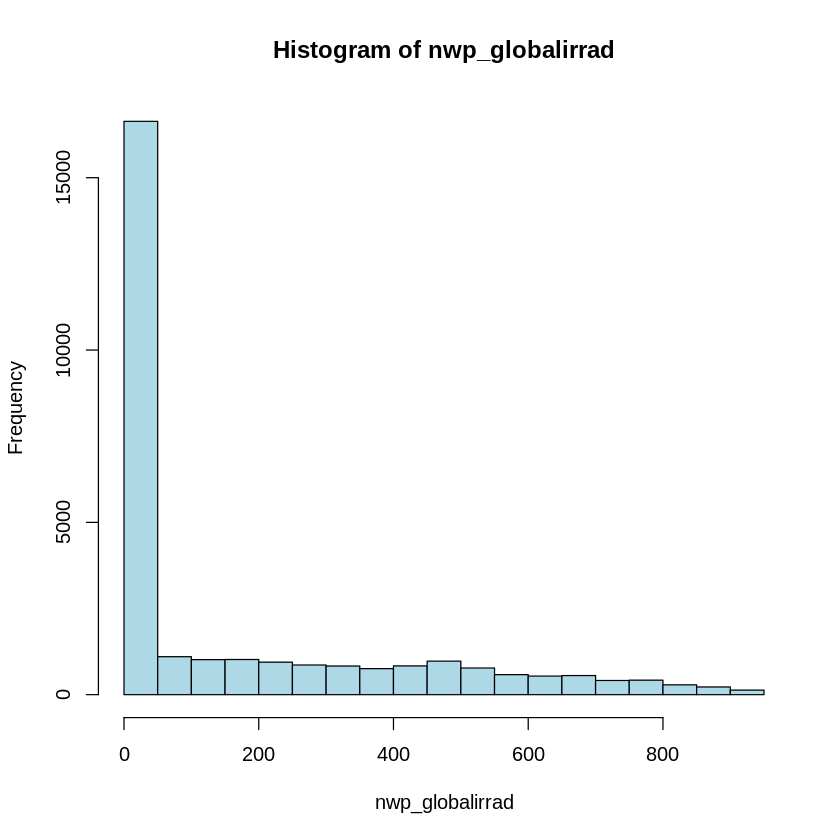

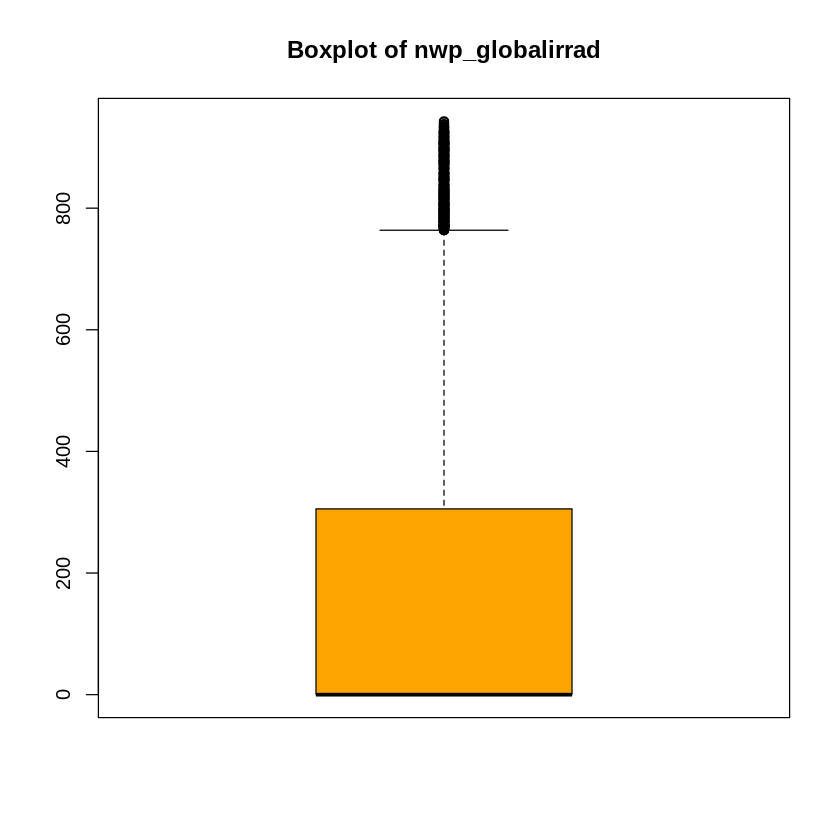

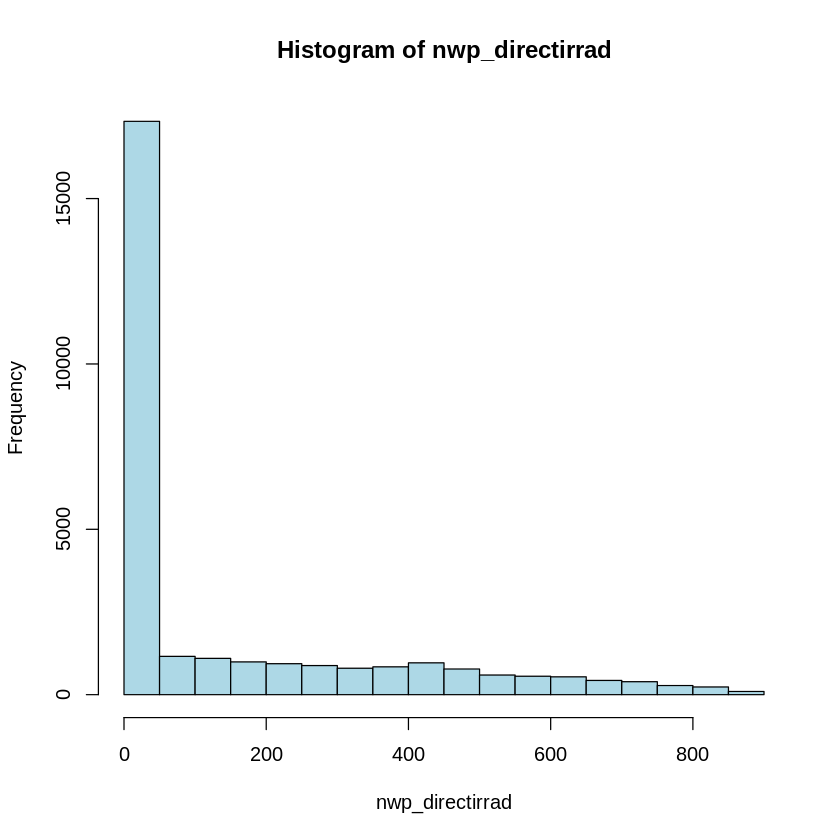

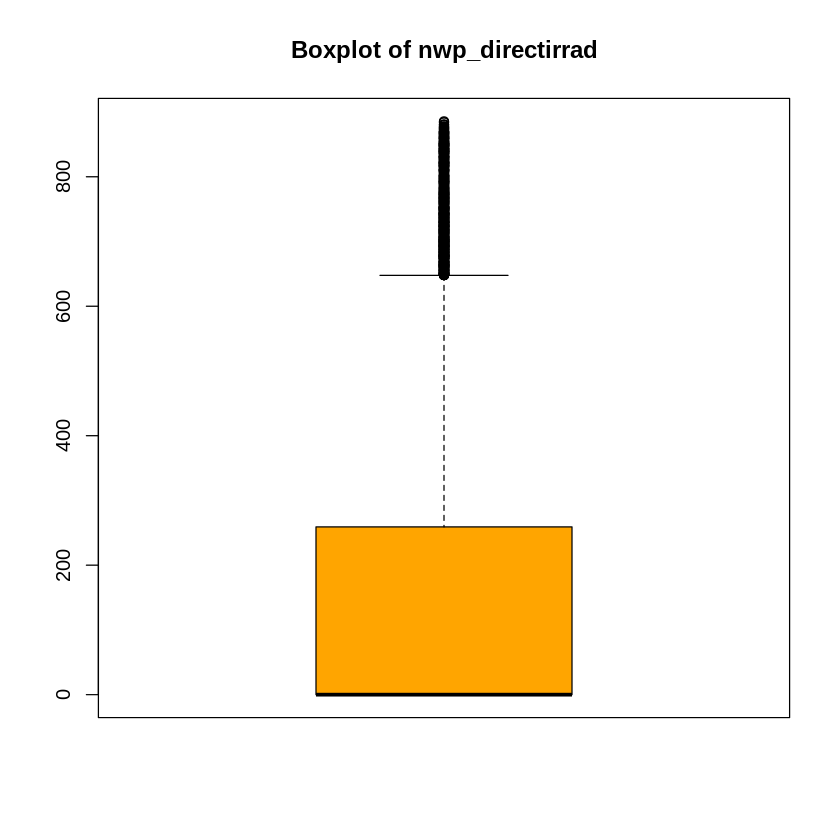

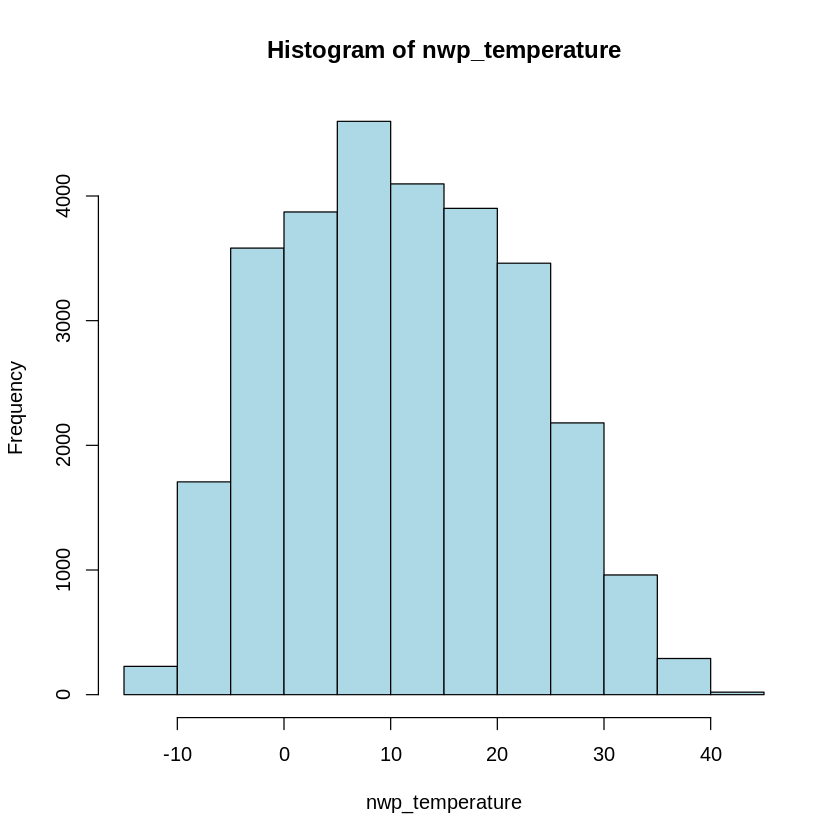

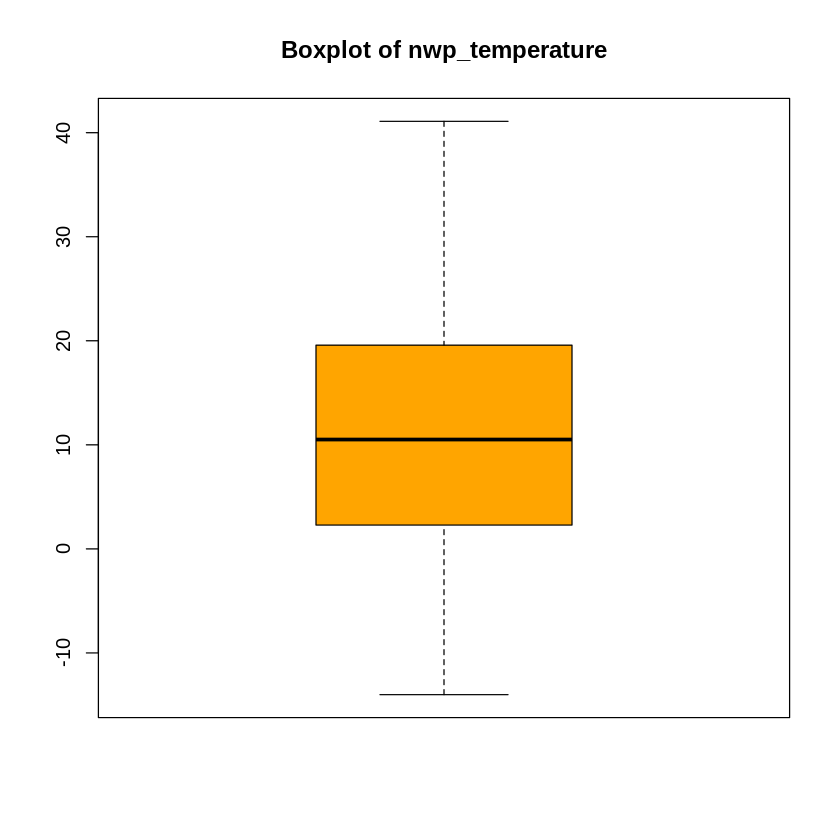

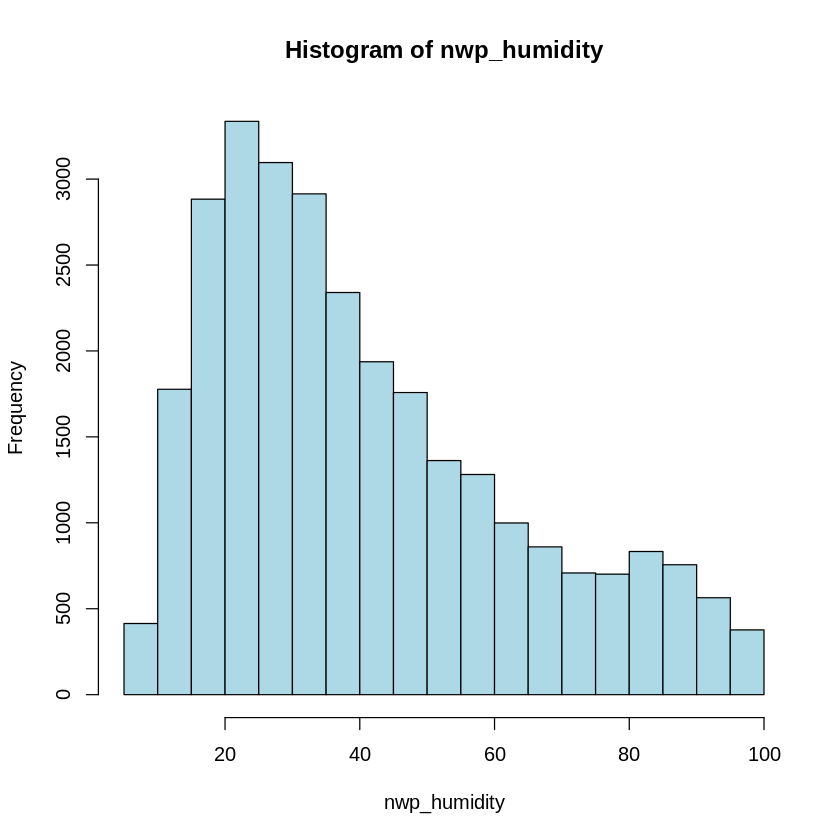

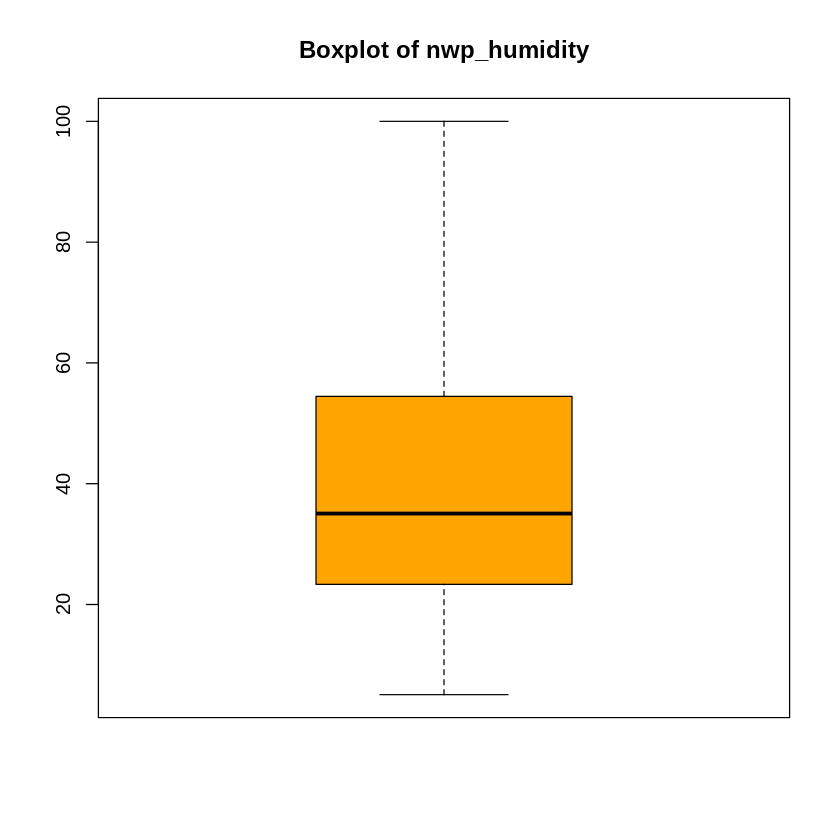

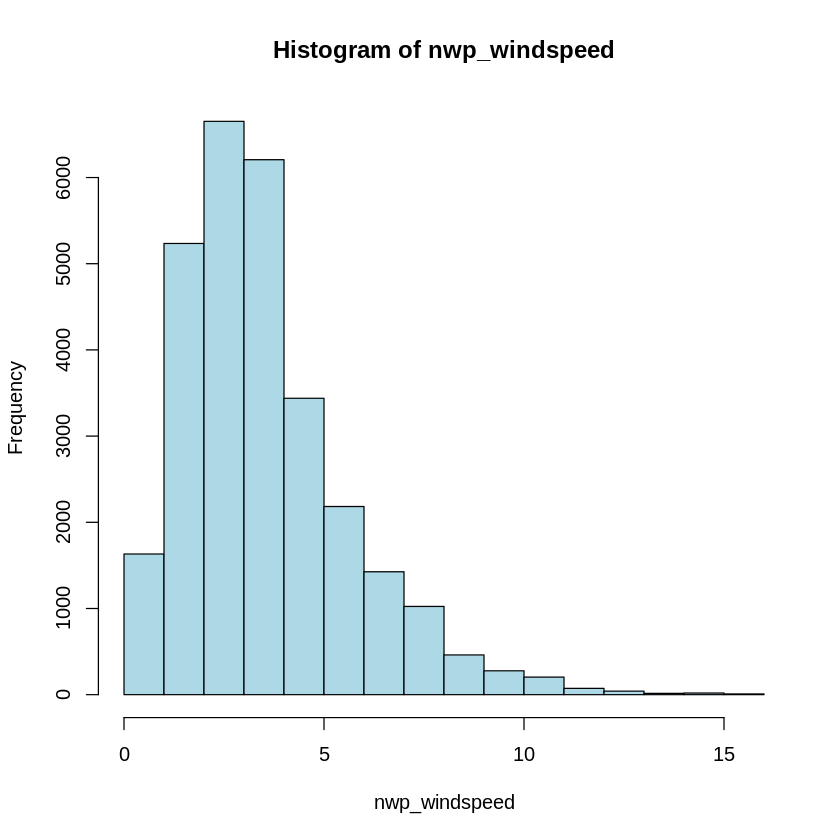

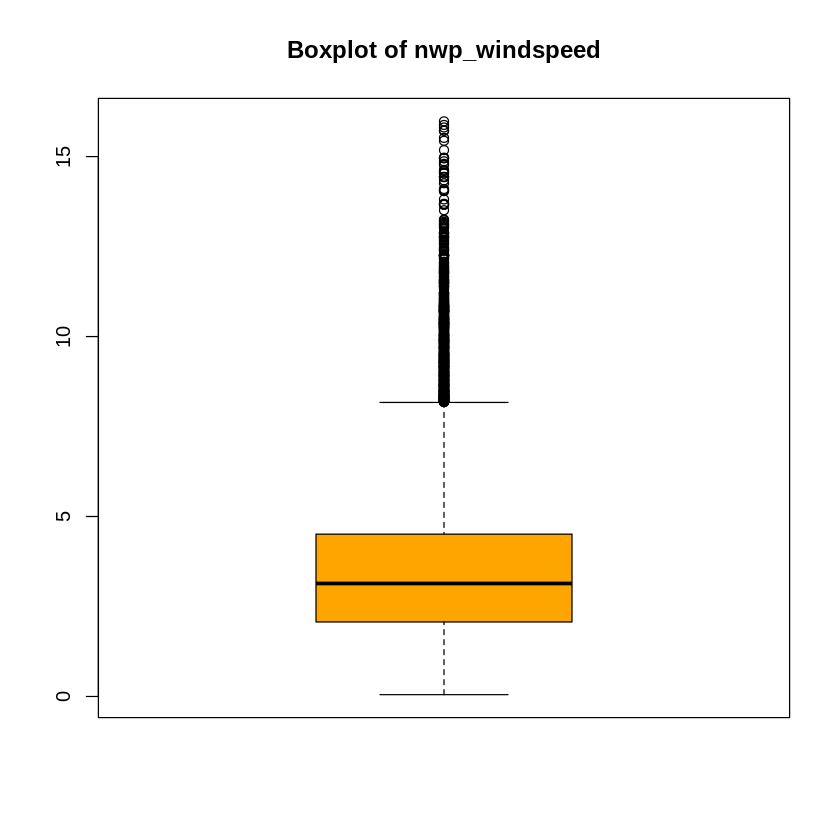

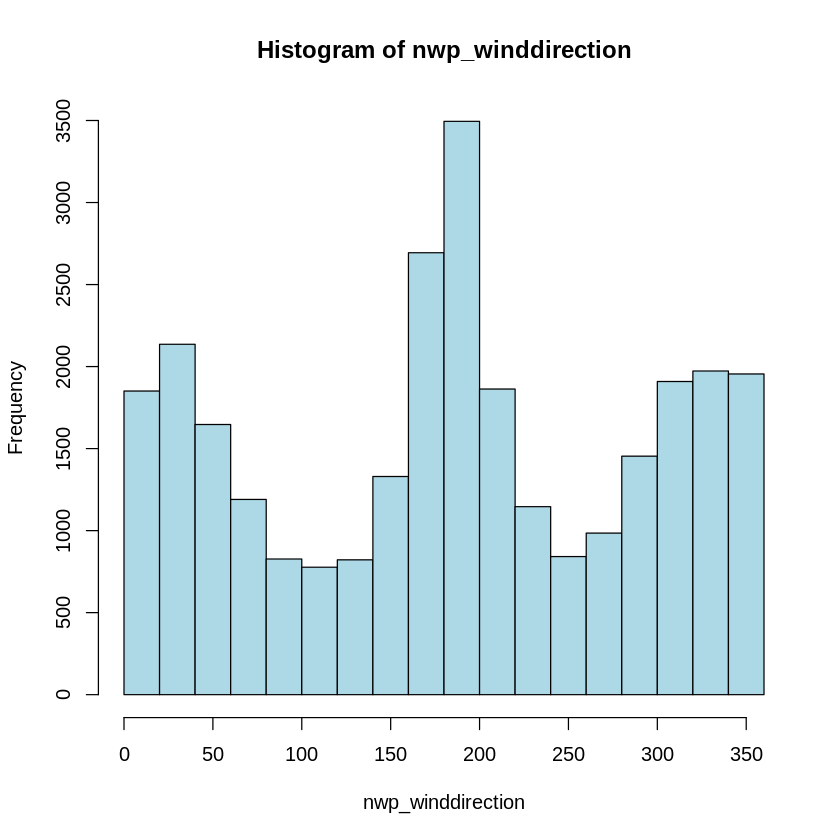

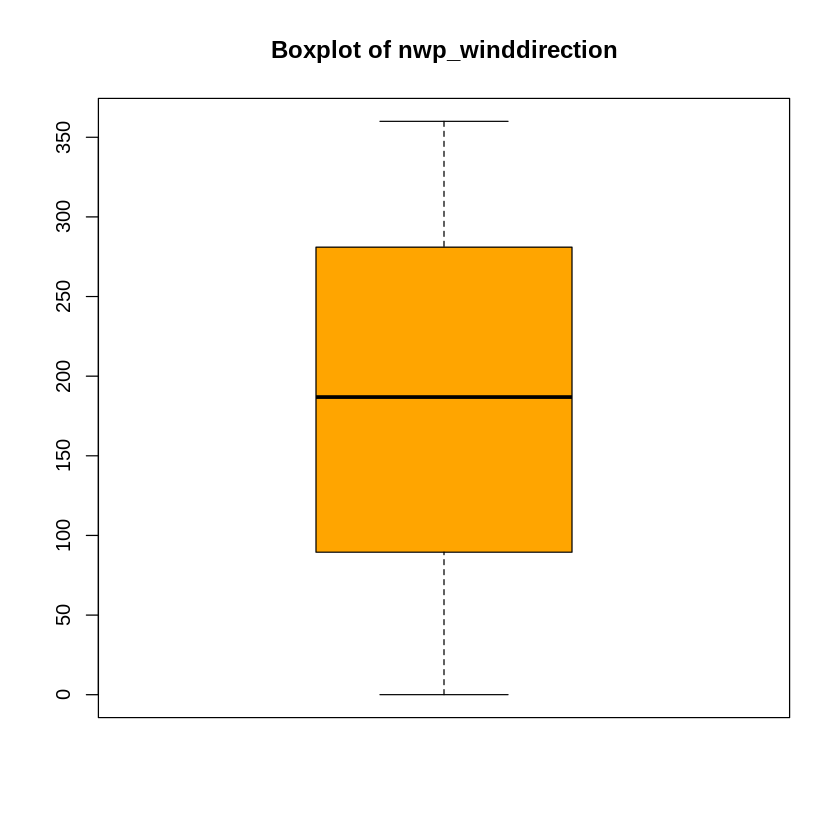

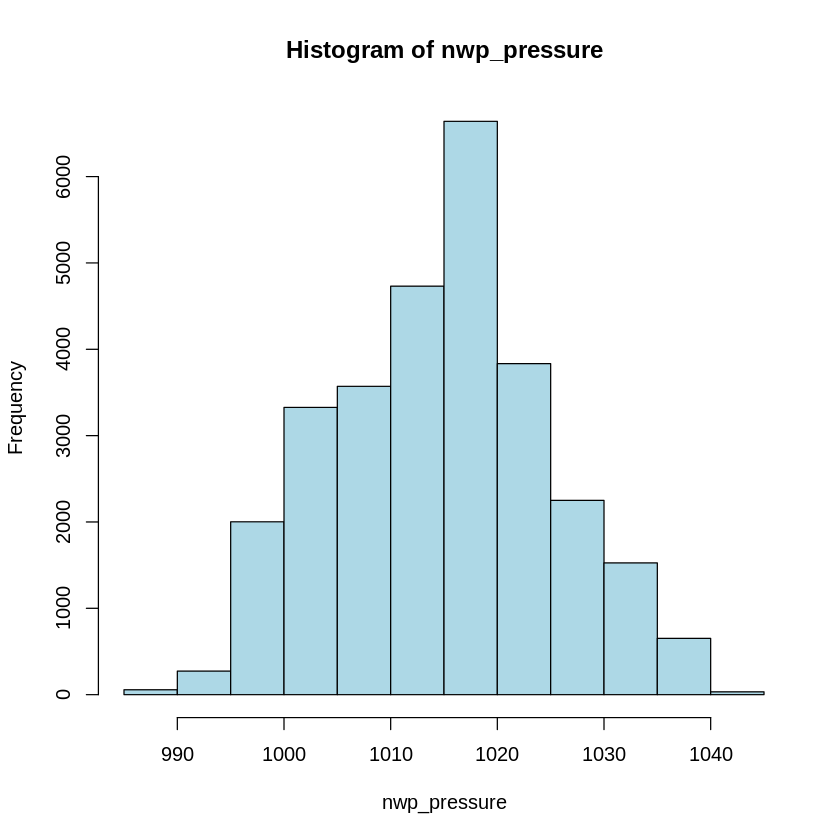

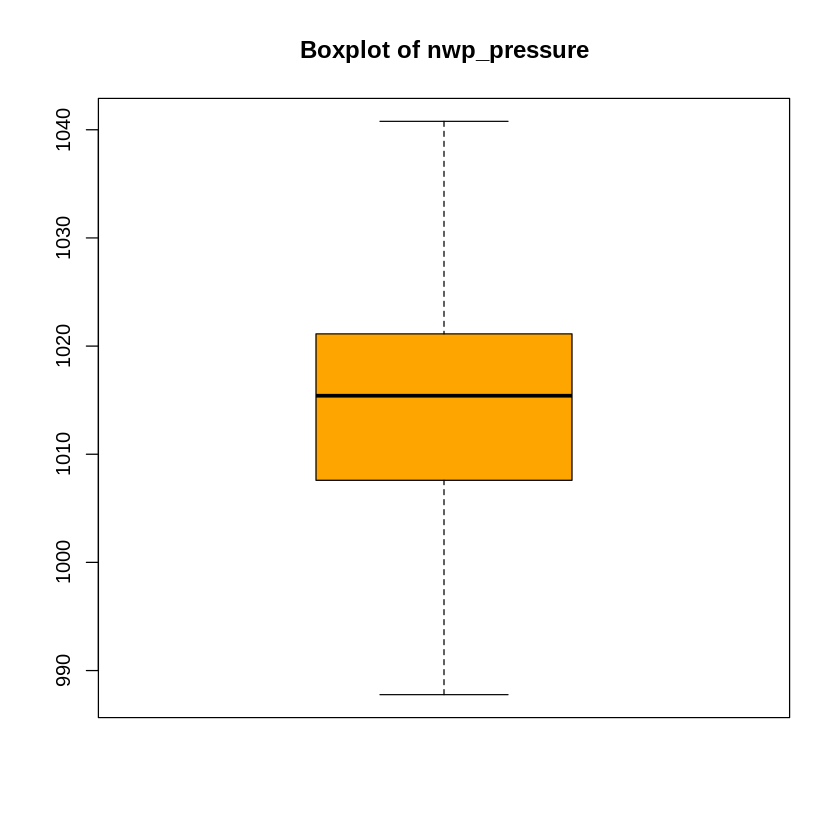

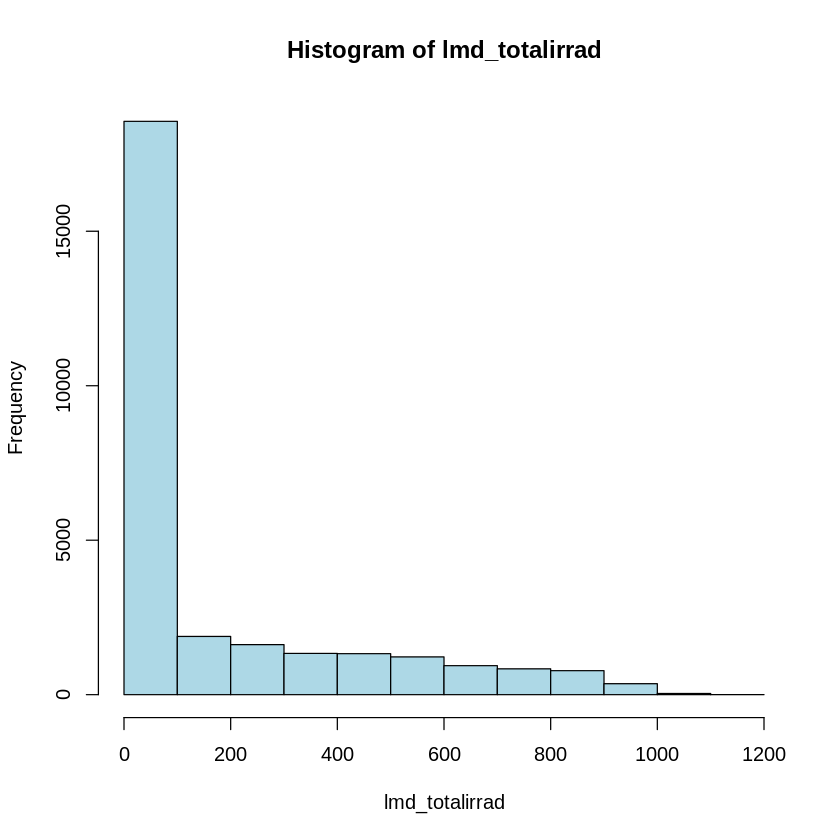

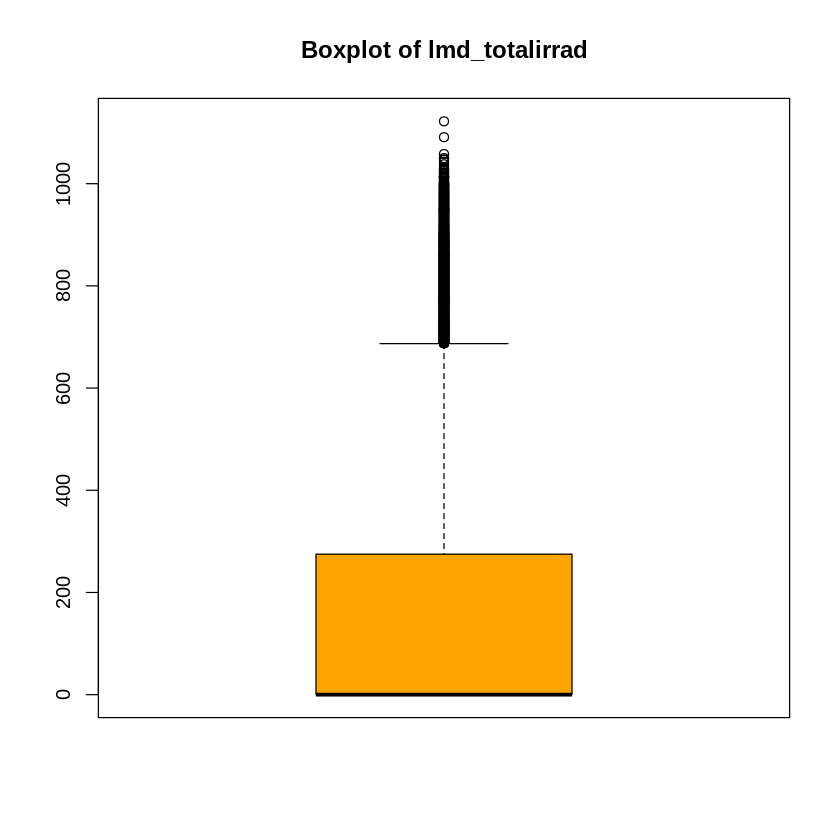

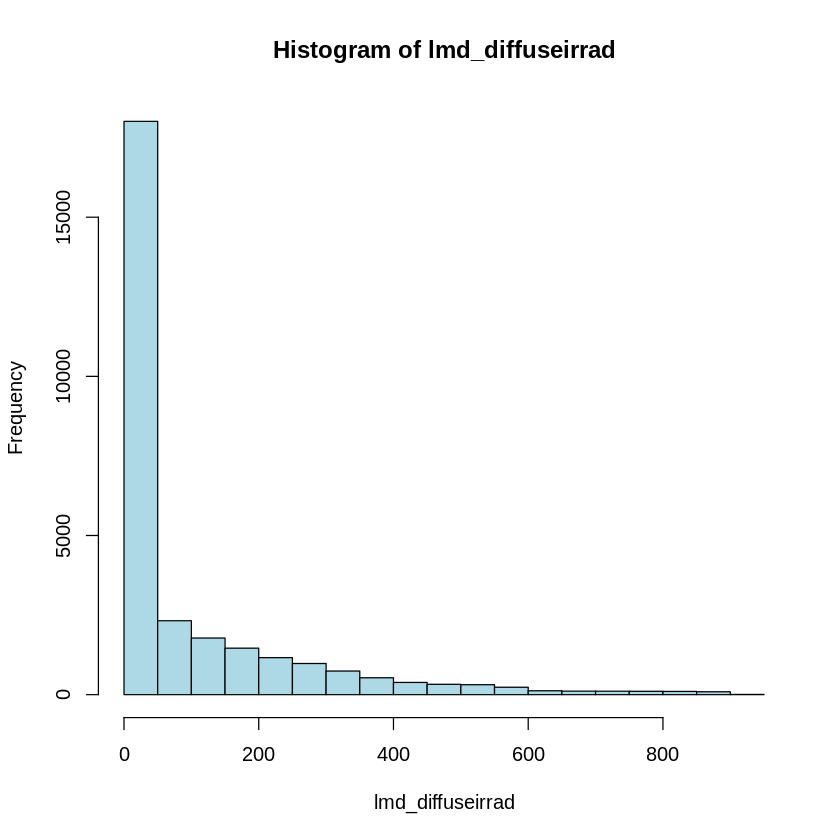

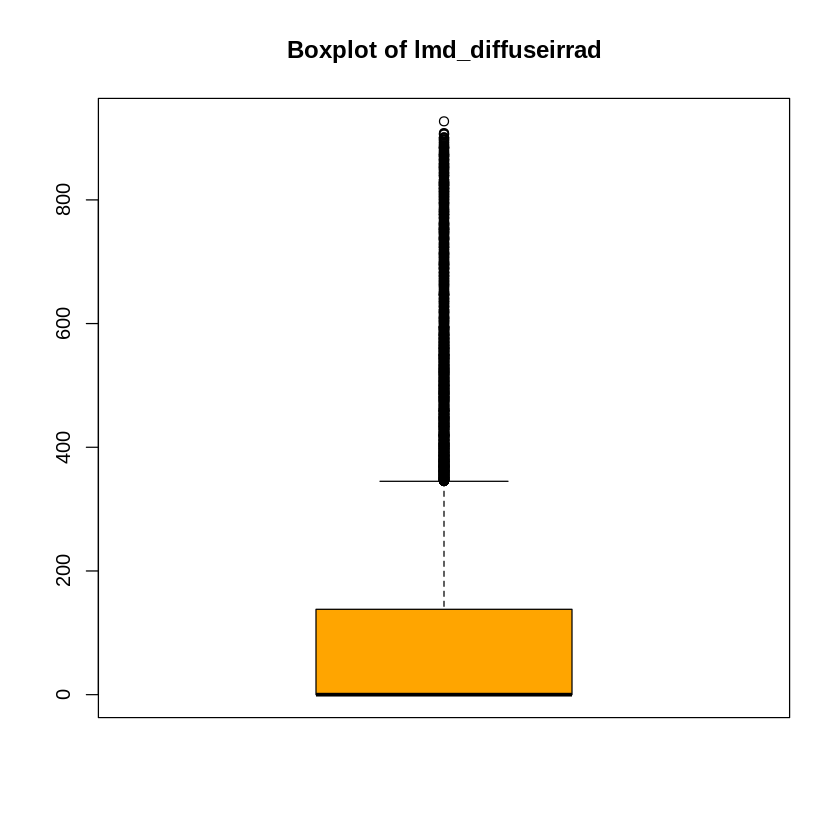

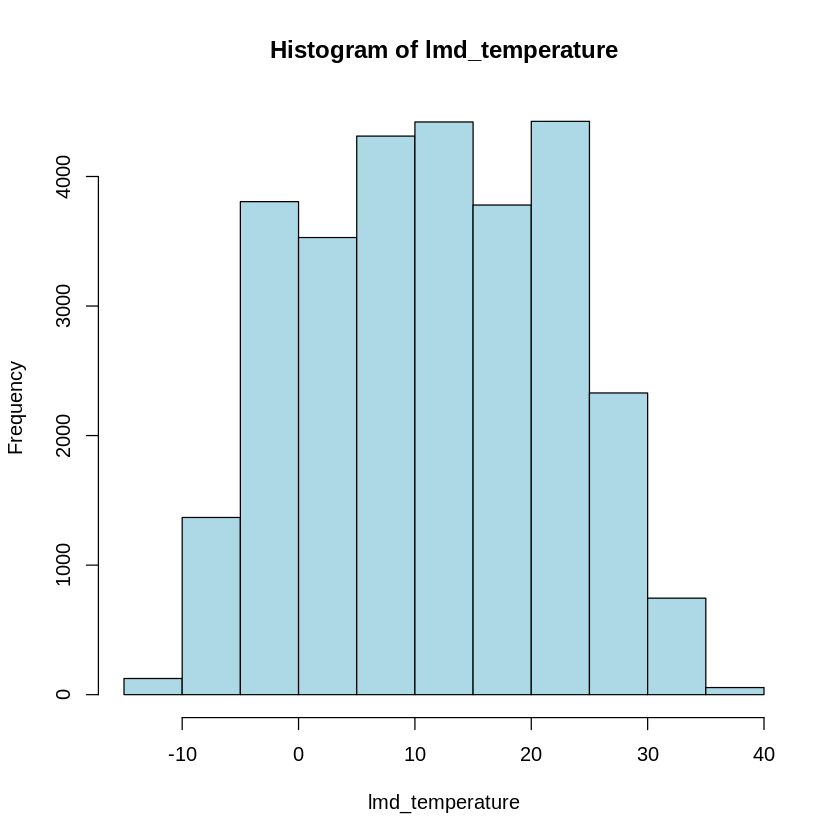

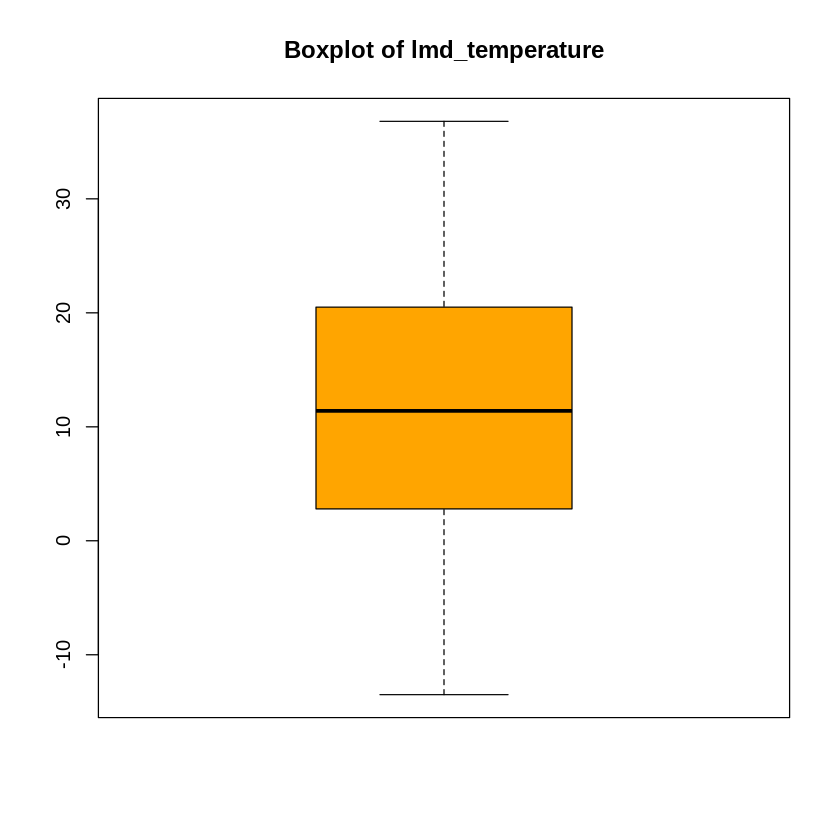

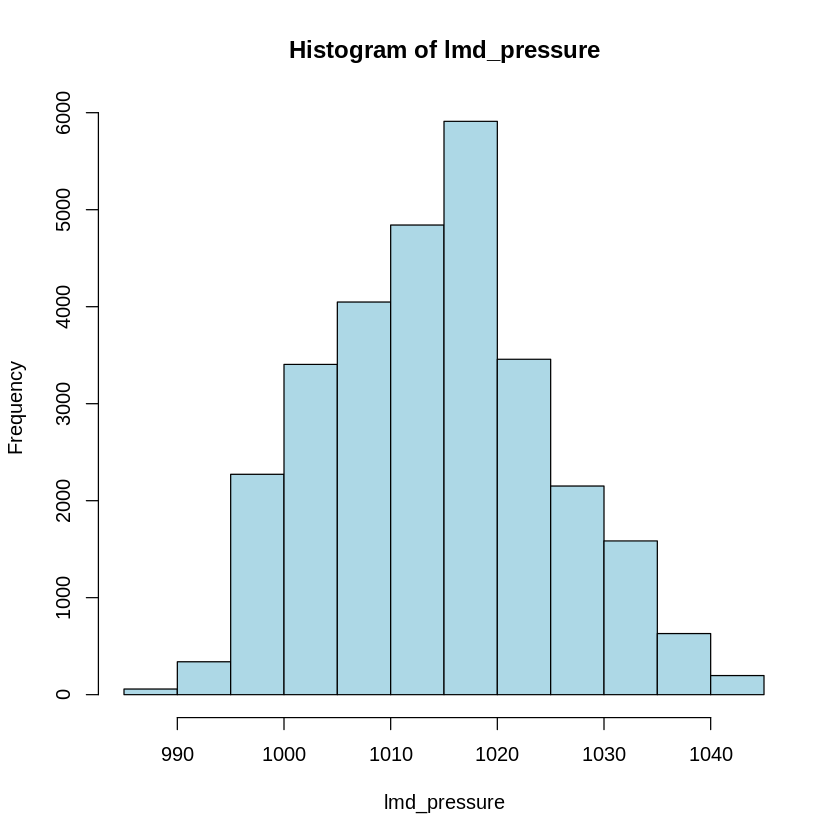

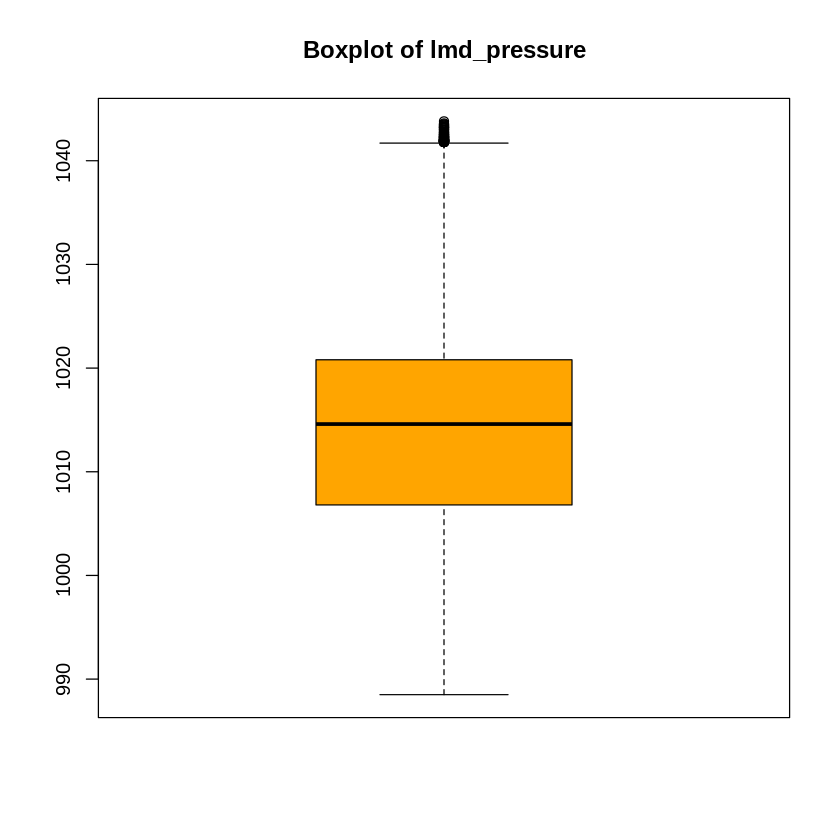

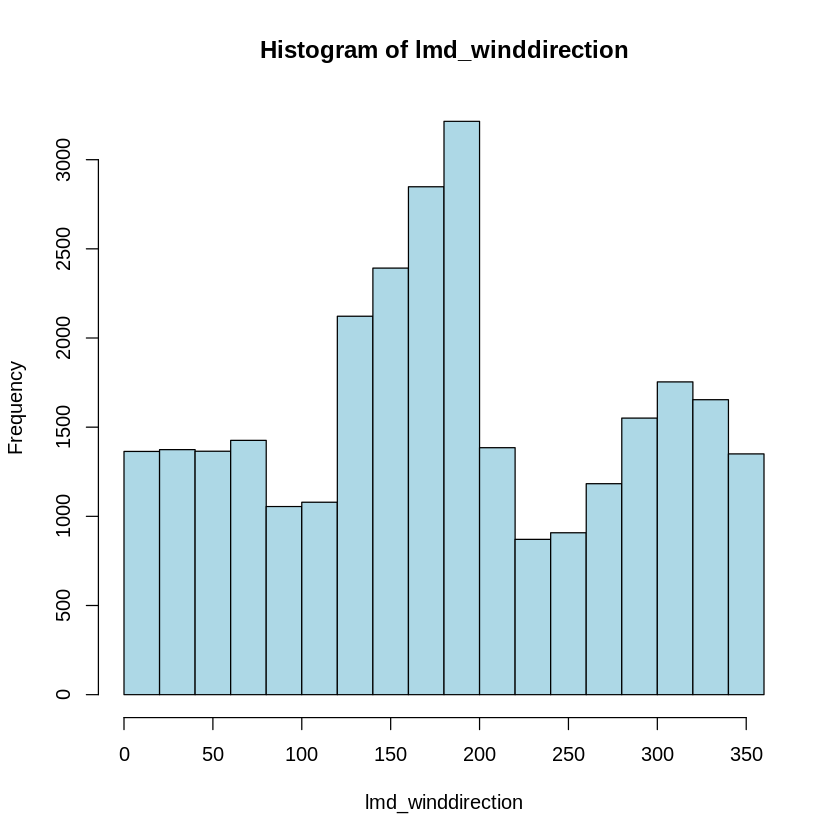

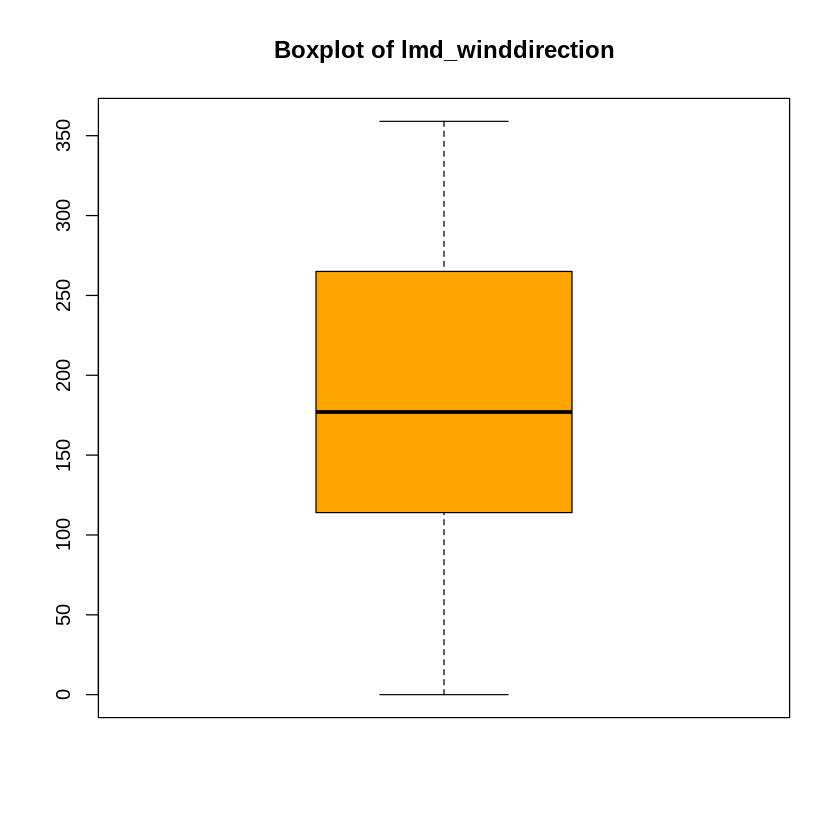

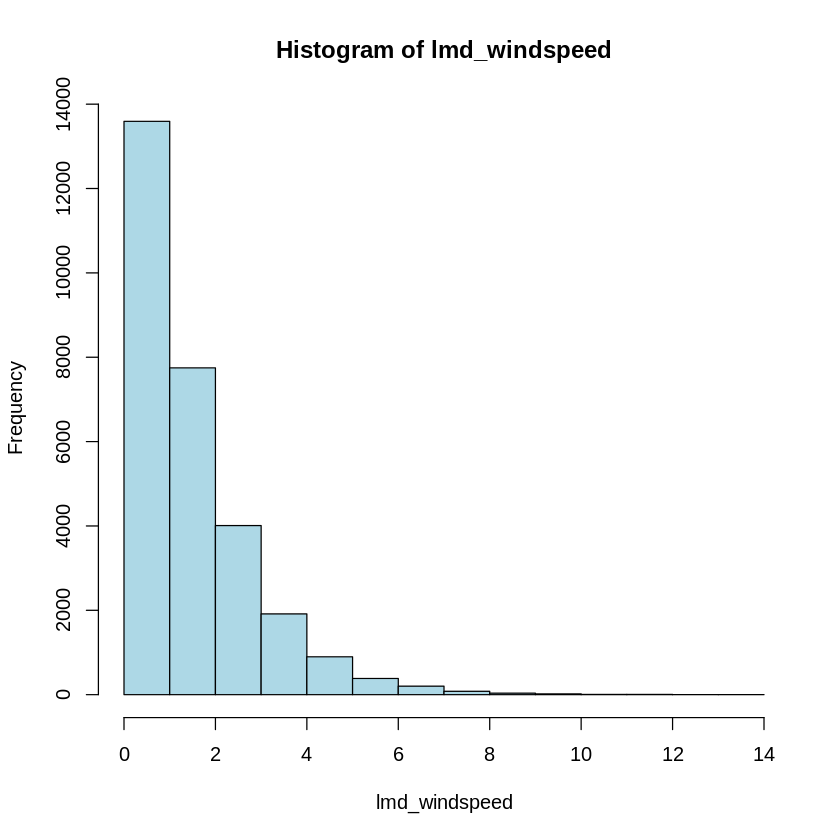

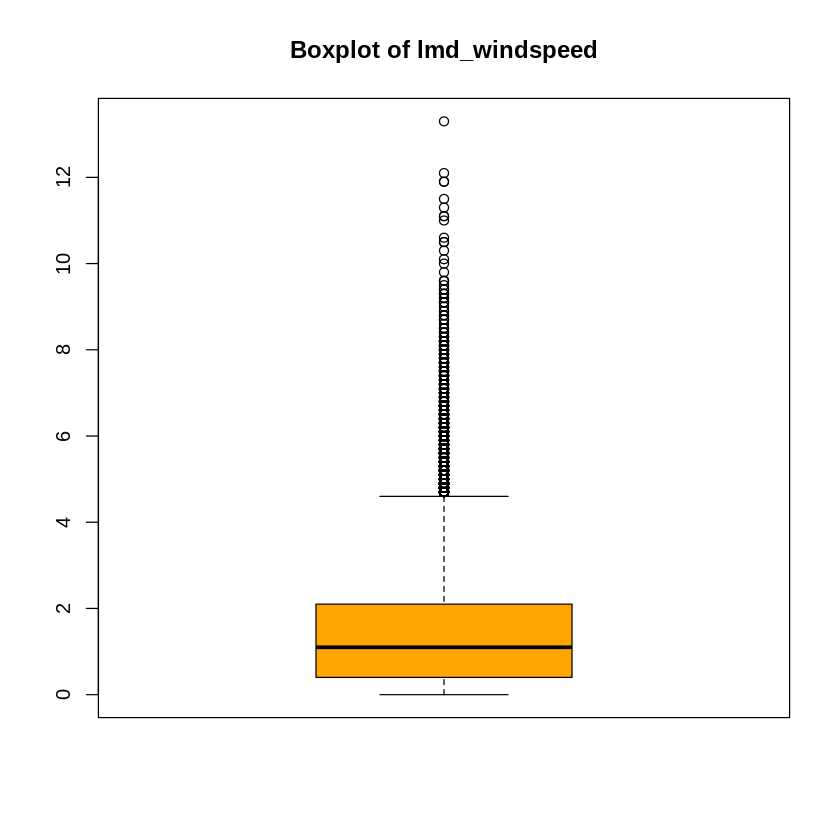

In [22]:
# Visualize dataset histograms and boxplots
cat("Visualizing dataset distributions...\n")
for (i in 2:(ncol(combined_dataset)-1)) {
  column_name <- names(combined_dataset)[i]
  hist(combined_dataset[[i]], main = paste("Histogram of", column_name), xlab = column_name, col = "lightblue")
  boxplot(combined_dataset[[i]], main = paste("Boxplot of", column_name), col = "orange")
}

In [23]:
# Subset the data to only use 300 samples
set.seed(42)
sampled_idx <- sample(1:nrow(combined_dataset), 300)
sampled_data <- combined_dataset[sampled_idx, ]

In [24]:
# Select middle 13 columns as features and last column as the target variable
if (ncol(combined_dataset) < 15) stop("Not enough columns in the dataset.")
X <- combined_dataset[, 2:(ncol(combined_dataset)-1)]  # Middle 13 columns as features
y <- combined_dataset$power  # Last column 'power' as the target

In [25]:
# Split into 80% training and 20% testing
set.seed(42)
n <- nrow(X)
train_idx <- sample(1:n, size = 0.8 * n)
test_idx <- setdiff(1:n, train_idx)
X_train <- as.matrix(X[train_idx, ])
y_train <- y[train_idx]
X_test <- as.matrix(X[test_idx, ])
y_test <- y[test_idx]
cat("Training and test data split completed. Training rows: ", nrow(X_train), " Testing rows: ", nrow(X_test), "\n")

Training and test data split completed. Training rows:  23116  Testing rows:  5780 


In [26]:
# ---------- Train LSTM Model ----------
cat("Training LSTM model...\n")
X_train_lstm <- array(X_train, dim = c(nrow(X_train), ncol(X_train), 1))
X_test_lstm <- array(X_test, dim = c(nrow(X_test), ncol(X_test), 1))

lstm_model <- keras_model_sequential() %>%
  layer_lstm(units = 10, input_shape = list(ncol(X_train), 1), return_sequences = FALSE) %>%
  layer_dense(units = 1)

lstm_model %>% compile(
  optimizer = 'adam',
  loss = 'mse'
)

lstm_model %>% fit(
  X_train_lstm, y_train, epochs = 10, batch_size = 30, verbose = 1
)

lstm_train_pred <- lstm_model %>% predict(X_train_lstm)
lstm_test_pred <- lstm_model %>% predict(X_test_lstm)

Training LSTM model...


In [27]:
# ---------- Train XGBoost Model ----------
cat("Training XGBoost model...\n")
dtrain <- xgb.DMatrix(data = X_train, label = y_train)
dtest <- xgb.DMatrix(data = X_test)

xgb_params <- list(
  objective = "reg:squarederror",
  eta = 0.1,
  max_depth = 3
)

xgb_model <- xgb.train(params = xgb_params, data = dtrain, nrounds = 50)

xgb_train_pred <- predict(xgb_model, X_train)
xgb_test_pred <- predict(xgb_model, X_test)

Training XGBoost model...


In [28]:
# ---------- Train Random Forest Model ----------
cat("Training Random Forest model...\n")
rf_model <- randomForest(X_train, y_train, ntree = 100)

rf_train_pred <- predict(rf_model, X_train)
rf_test_pred <- predict(rf_model, X_test)

Training Random Forest model...


In [29]:
# ---------- Stacking (Meta Learner) ----------
cat("Training meta-learner (linear regression)...\n")
stack_train <- data.frame(
  lstm = lstm_train_pred,
  xgb = xgb_train_pred,
  rf = rf_train_pred
)

stack_test <- data.frame(
  lstm = lstm_test_pred,
  xgb = xgb_test_pred,
  rf = rf_test_pred
)

meta_model <- lm(y_train ~ ., data = stack_train)

final_train_pred <- predict(meta_model, stack_train)
final_test_pred <- predict(meta_model, stack_test)

Training meta-learner (linear regression)...


In [30]:
# ---------- Model Evaluation ----------
cat("Evaluating models using RMSE and R-squared...\n")
rmse <- function(actual, predicted) {
  sqrt(mean((actual - predicted)^2))
}

r_squared <- function(actual, predictions) {
  ss_res <- sum((actual - predictions)^2)  # Residual sum of squares
  ss_tot <- sum((actual - mean(actual))^2)  # Total sum of squares
  1 - (ss_res / ss_tot)
}

Evaluating models using RMSE and R-squared...


In [31]:
train_rmse <- rmse(y_train, final_train_pred)
test_rmse <- rmse(y_test, final_test_pred)

cat("Train RMSE: ", train_rmse, "\n")
cat("Test RMSE: ", test_rmse, "\n")

Train RMSE:  0.05270842 
Test RMSE:  0.1473934 


In [32]:
train_r_squared_value <- r_squared(y_train, final_train_pred)
test_r_squared_value <- r_squared(y_test, final_test_pred)

cat("Train R-squared: ", train_r_squared_value, "\n")
cat("Test R-squared: ", test_r_squared_value, "\n")

Train R-squared:  0.9983243 
Test R-squared:  0.9865359 


In [33]:
# Visualizing RMSE comparison
cat("Visualizing RMSE comparison...\n")
rmse_data <- data.frame(
  dataset = c("Training", "Testing"),
  rmse_value = c(train_rmse, test_rmse)
)

Visualizing RMSE comparison...


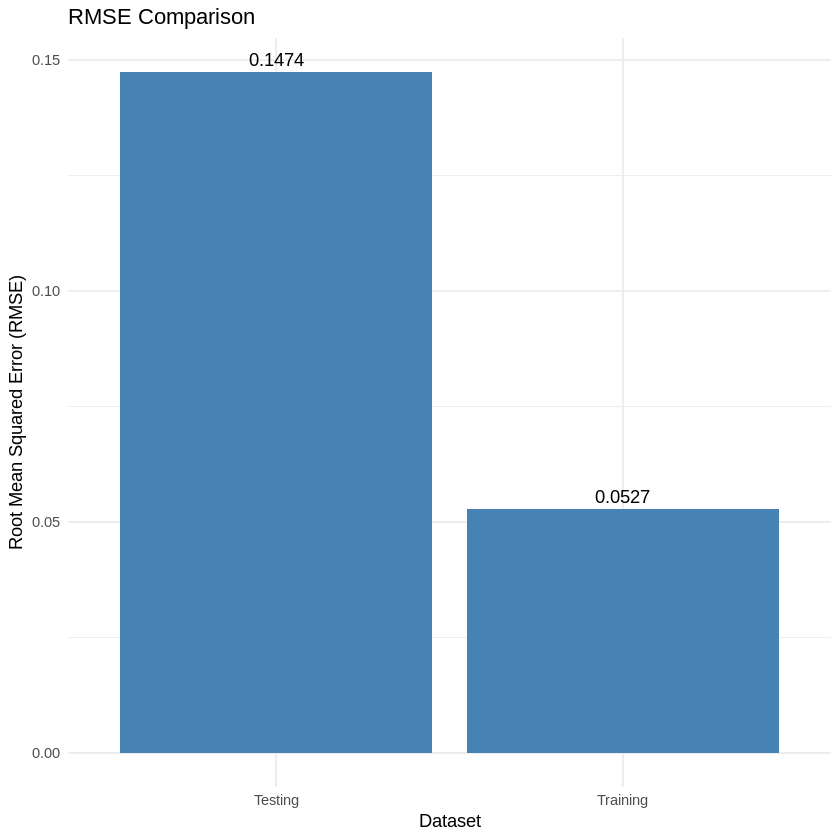

In [34]:
ggplot(rmse_data, aes(x = dataset, y = rmse_value)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_text(aes(label = round(rmse_value, 4)), vjust = -0.5) +
  labs(title = "RMSE Comparison", x = "Dataset", y = "Root Mean Squared Error (RMSE)") +
  theme_minimal()

Visualizing predicted vs actual for training and testing sets...


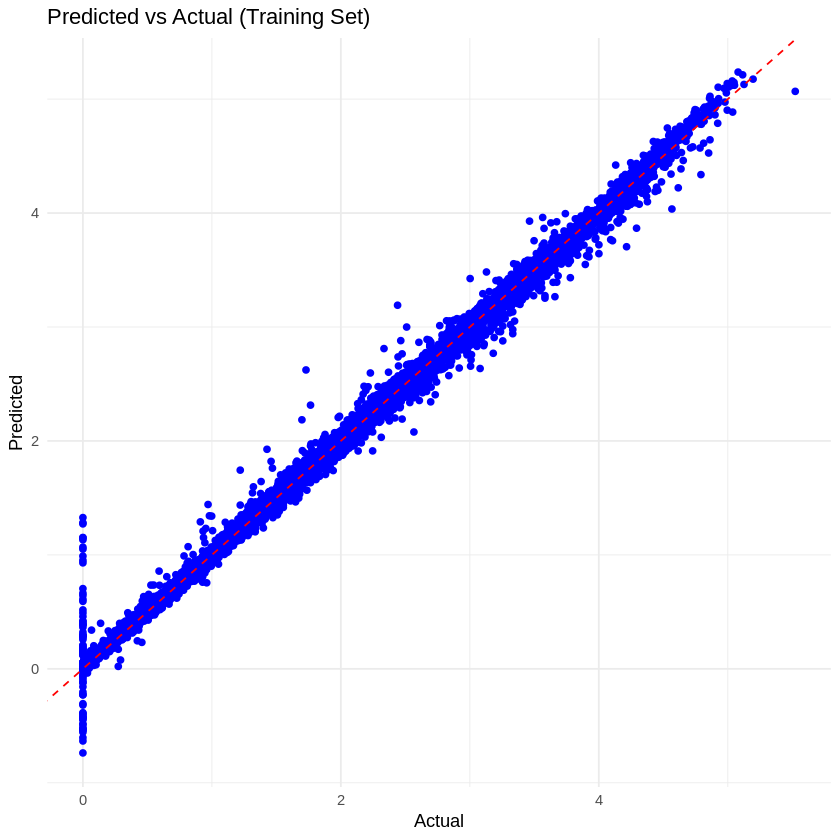

In [35]:
# Visualizing predicted vs actual values for training set
cat("Visualizing predicted vs actual for training and testing sets...\n")
ggplot(data.frame(actual = y_train, predicted = final_train_pred), aes(x = actual, y = predicted)) +
  geom_point(color = "blue") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Predicted vs Actual (Training Set)", x = "Actual", y = "Predicted") +
  theme_minimal()

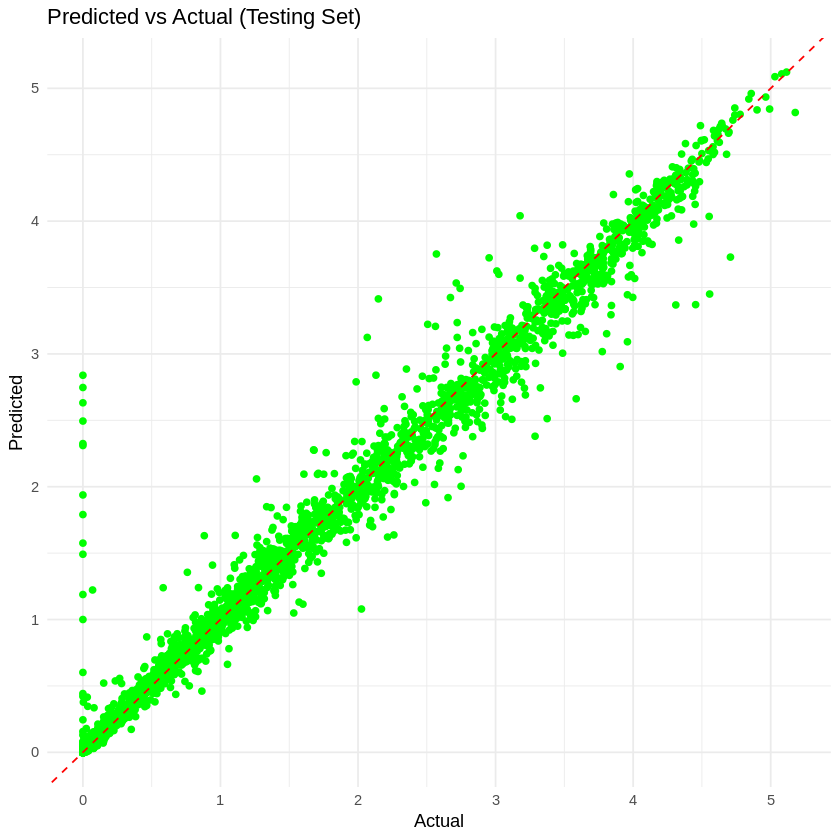

In [36]:
# Visualizing predicted vs actual values for testing set
ggplot(data.frame(actual = y_test, predicted = final_test_pred), aes(x = actual, y = predicted)) +
  geom_point(color = "green") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Predicted vs Actual (Testing Set)", x = "Actual", y = "Predicted") +
  theme_minimal()

In [37]:
cat("Model evaluation and visualizations completed.\n")

Model evaluation and visualizations completed.
